# Text Mining Coursework 2
## Topic: WinterOlympics
### 3 Questions: 
1) What is the dominant sentiment towards the Winter Olympics?

2) Which sport is the most talked about?

3) Which country has been mostly talked about during Winter Olympics? What are the people's opinion of that country?

## Libraries Used

In [1]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

/Users/cyc/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/Users/cyc/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


# Configuring Twitter API

In [2]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [3]:
# tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# print(tweet_urls)

## Convert urls to tweets

In [4]:
# # Extract the tweet id
# tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# # Store tweet id in another column
# tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
# ids = tweet_urls['tweet_ids'].tolist()

# def url2tweet(IDs): # a list of ids, max 100
#     all_status = api.lookup_statuses(IDs)
#     tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
#     return tweets_list


# def get_all_tweets(IDs): # a list of ids
#     num_sections = (len(IDs) - 1) // 100 + 1
#     first_section = ids[:100]
#     data = url2tweet(first_section)
#     for i in tqdm(range(1, num_sections)):
#         current_ids = ids[i*100:(i+1)*100]
#         current_tweet_list = url2tweet(current_ids)
#         data = np.concatenate([data, current_tweet_list])
#     return data

# data = get_all_tweets(ids)

In [5]:
# tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
# tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
# tweets_df.head(len(tweets_df))

# Data Cleaning

In [6]:
# def remove_emoji(string):
#     string = emoji.get_emoji_regexp().sub(u'', string)
#     return string

# emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# print(remove_emoji(emojis))

In [7]:
# def data_cleaning(data):
#     # Remove hyperlinks
#     data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

#     # Remove punctuation
#     data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

#     # Remove unnecessary line breaks
#     data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

#     # Convert the titles to lowercase
#     data.text = data.text.map(lambda x: x.lower())

#     # Remove emojis
#     data.text = data.text.map(lambda x: remove_emoji(x))

In [17]:
# # Uncomment the line below if loading from previously saved CSV
# tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

# data_cleaning(tweets_df)

# # store the processed tweets to csv
# tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 2: What were poeple mostly talking about for the Winter Olympics?

## Exploration using a word cloud

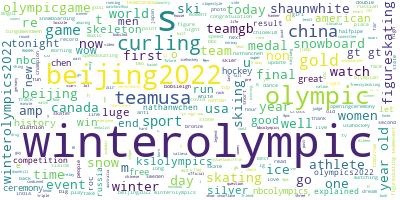

In [13]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets = list(set(list(tweets_df['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [14]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'today', 'like', 
                   'would', 'watch', 'tonight', 'first', 'time', 'go', 'next', 'events', 'let', 
                   'love', 'year', 'watching', 'day', 'run', 'big', 'live', 'know', 'well','going', 'great'
                   , 'get', 'one', 'good', 'th', 'white', 'back','game', 'amp', 'end', 'see', 'watchwithus'
                   , 'much'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Topics

In [15]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.021*"teamusa" + 0.014*"team" + 0.013*"curling" + 0.012*"women" + '
  '0.009*"hockey" + 0.008*"gold" + 0.008*"men" + 0.008*"ice" + 0.006*"medal" + '
  '0.005*"win"'),
 (1,
  '0.011*"china" + 0.007*"skating" + 0.007*"athletes" + 0.006*"teamusa" + '
  '0.005*"chinese" + 0.005*"sport" + 0.005*"figure" + 0.004*"curling" + '
  '0.004*"sports" + 0.004*"last"'),
 (2,
  '0.021*"gold" + 0.016*"team" + 0.015*"medal" + 0.012*"usa" + '
  '0.010*"figureskating" + 0.008*"men" + 0.007*"women" + 0.007*"teamusa" + '
  '0.007*"skating" + 0.006*"nathan"'),
 (3,
  '0.024*"curling" + 0.007*"teamgb" + 0.007*"nbc" + 0.006*"ski" + '
  '0.006*"women" + 0.005*"sport" + 0.005*"ice" + 0.005*"event" + 0.005*"gold" '
  '+ 0.004*"could"'),
 (4,
  '0.012*"curling" + 0.011*"gold" + 0.009*"skating" + 0.008*"final" + '
  '0.008*"figure" + 0.008*"ceremony" + 0.007*"opening" + 0.007*"skiing" + '
  '0.006*"usa" + 0.006*"women"')]


### Visualise the topics

In [16]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.046382  0.072124       1        1  23.761867
0      0.025483  0.007134       2        1  20.209390
3     -0.009265 -0.069118       3        1  20.026810
1     -0.103494  0.025990       4        1  19.348827
4      0.040894 -0.036131       5        1  16.653106, topic_info=        Term         Freq        Total Category  logprob  loglift
26   curling  4346.000000  4346.000000  Default  30.0000  30.0000
112  teamusa  3158.000000  3158.000000  Default  29.0000  29.0000
14      team  3124.000000  3124.000000  Default  28.0000  28.0000
55      gold  3839.000000  3839.000000  Default  27.0000  27.0000
115      usa  1917.000000  1917.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
35       win   170.220443  1064.788275   Topic5  -5.9193  -0.0409
127   hockey   173.218199  1273.504616   Topic5  -5.9019  -0.2024
14      team   186.277933  3124.464602   Topic5  -5.8292  -1.0272
112  teamusa   179.426934  3158.006897   Topic5  -5.8667  -1.0754
790   canada   150.386747   892.905320   Topic5  -6.0432   0.0113

[456 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
10063      2  0.955498    abby_roque
2237       5  0.964080       ability
6966       2  0.041999        abuses
6966       4  0.839979        abuses
6966       5  0.083998        abuses
...      ...       ...           ...
6941       5  0.590012        yuzuru
3685       1  0.160049  zachtdonohue
3685       2  0.760233  zachtdonohue
3685       4  0.060018  zachtdonohue
1977       3  0.922101           zhi

[1109 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])

# Hence, from the visualisation above we can conclude, people were mostly talking about these topics for the Winter Olympics:
$ Gold medal $, $curling$, $china$, $woman$ and $team USA$

# Task 1: What is the dominant sentiment towards the Winter Olympics?

# Sentiment Analysis

In [18]:
all_pos = []
all_neg = []
dates = np.arange(4, 20)
for date in dates:
    neu = []
    pos = []
    neg = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
    
    all_pos.append(pos)
    all_neg.append(neg)

## Get rates of positive/negative

In [19]:
rates = []
for i in range(len(all_pos)):
    cur_pos = [x for x in all_pos[i] if x > 0.3]
    cur_neg = [x for x in all_neg[i] if x > 0.3]
    rates.append(len(cur_pos)/len(cur_neg))

## Visualise the rates

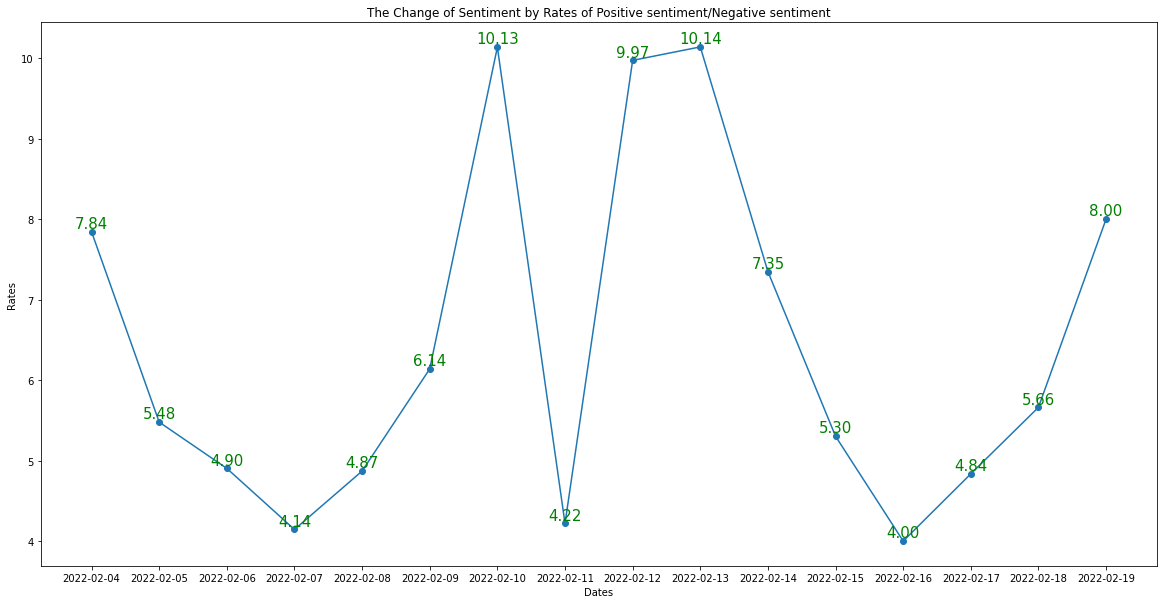

In [20]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(20,10))
plt.plot(rates, 'o-')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Rates')
plt.title("The Change of Sentiment by Rates of Positive sentiment/Negative sentiment")
x = dates
y = np.array(rates)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.01, '%.2f'%_y, ha='center', va='bottom', size=15, c='green')
plt.show()

# Task 3: Which country has been mostly talked about during Winter Olympics? What are the people's opinion of that country?

# Named Entity Recognition

In [21]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

In [59]:
# athletes = []
countries = {}
stop_words = ['beijing2022', 'beijing']

for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
#     print(tweet_text)
    for ne in doc.ents:
#         if ne.label_ == 'GPE' or ne.label_ == 'LOC':
#         print(ne.label_)
        if ne.label_ == 'GPE':
            tweet = tweet_text[ne.start_char:ne.end_char]
            if tweet not in stop_words and tweet not in countries.keys():
                countries[tweet] = 1
            elif tweet not in stop_words:
                countries[tweet] += 1

In [67]:
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}
mostly_talked_country = list(countries.keys())[0]
print("The Mostly Talked Country is", mostly_talked_country)

The Mostly Talked Country is britain


In [75]:
all_pos = []
all_neg = []
dates = np.arange(4, 20)
for date in dates:
    neu = []
    pos = []
    neg = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
#     print(cur_date)
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains('britain')]
#     print(tweets_df_copy)
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
    
    all_pos.append(pos)
    all_neg.append(neg)
    
#     break

In [79]:
print(all_pos)
print(all_neg)

[[0.163, 0.451, 0.171, 0.431, 0.365, 0.606, 0.369, 0.171, 0.349, 0.349, 0.186, 0.302], [0.0, 0.406, 0.374, 0.094, 0.415, 0.0], [0.0, 0.279, 0.11], [0.168, 0.227, 0.194, 0.207, 0.184], [0.357, 0.247, 0.292, 0.31], [0.309, 0.379, 0.378, 0.102, 0.369, 0.381], [0.0, 0.255, 0.172, 0.189, 0.385, 0.237, 0.291, 0.255], [0.312, 0.0, 0.194, 0.363, 0.44], [0.285, 0.0, 0.215, 0.0, 0.429, 0.177, 0.349], [0.194, 0.281], [0.145, 0.0, 0.237, 0.323, 0.0], [0.091, 0.0, 0.194, 0.249, 0.0, 0.121, 0.164, 0.358, 0.283], [0.202, 0.239, 0.275, 0.261, 0.194], [0.296, 0.192, 0.397, 0.383, 0.455, 0.0, 0.272, 0.156, 0.155, 0.301, 0.237, 0.0, 0.247, 0.331, 0.545, 0.0, 0.273, 0.148, 0.183, 0.558, 0.275, 0.141, 0.34, 0.444, 0.318, 0.24, 0.333], [0.508, 0.391, 0.297, 0.339, 0.167, 0.0, 0.406, 0.0, 0.259, 0.0, 0.313, 0.257, 0.317, 0.423, 0.369, 0.0, 0.367, 0.194, 0.244, 0.479, 0.162, 0.142, 0.0], [0.194, 0.207, 0.186, 0.257, 0.434, 0.0, 0.313, 0.394, 0.27, 0.112, 0.171, 0.34, 0.353, 0.217, 0.313, 0.227, 0.324, 0.303, 

In [88]:
rates = []
for i in range(len(all_pos)):
#     print(i)
    cur_pos = [x for x in all_pos[i] if x > 0.2]
#     print(cur_pos)
    cur_neg = [x for x in all_neg[i] if x > 0.05]
#     print(cur_neg)
#     num_pos = len(cur_pos) if len(cur_pos) > 0 else len(cur_pos)+1
#     num_neg = len(cur_neg) if len(cur_neg) > 0 else len(cur_neg)+1
    
#     rates.append(num_pos/num_neg)
    rates.append(len(cur_neg)/len(cur_pos))

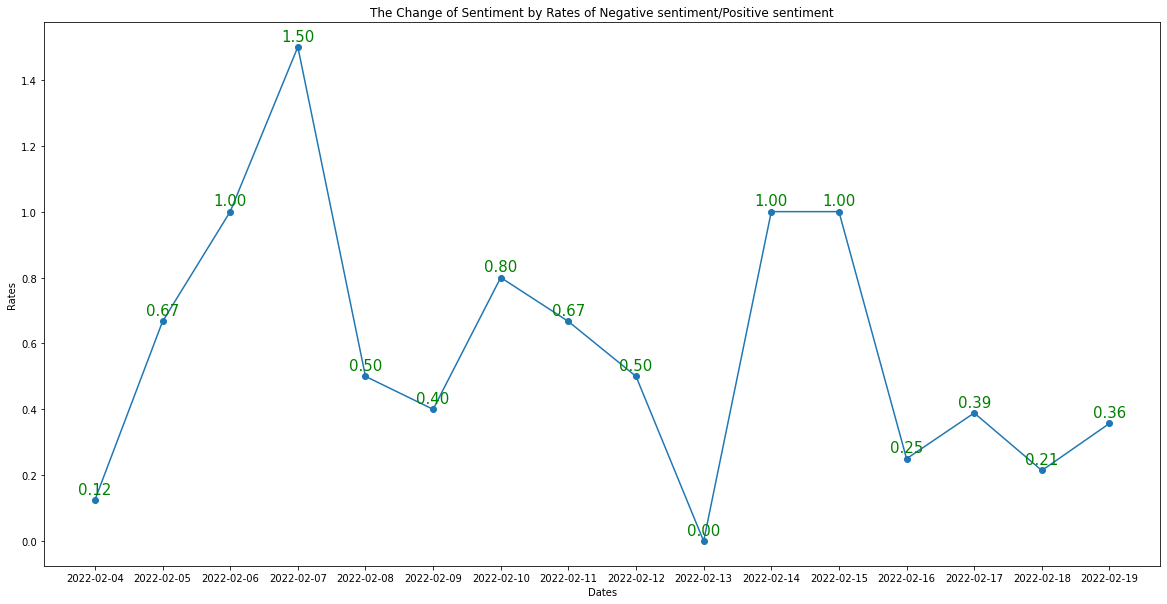

In [89]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(20,10))
plt.plot(rates, 'o-')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Rates')
plt.title("The Change of Sentiment by Rates of Negative sentiment/Positive sentiment")
x = dates
y = np.array(rates)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.01, '%.2f'%_y, ha='center', va='bottom', size=15, c='green')
plt.show()

# Named Entity Linking

In [27]:
# nlp = spacy.load("en_core_web_md")

# #add to pipeline
# nlp.add_pipe('entityLinker', last=True)

In [26]:
# for tweet_text in unique_tweets:
#     try:
#         doc = nlp(tweet_text)
#         print(tweet_text)
#         all_linked_entities = doc._.linkedEntities
#         for linked_entity in all_linked_entities:
#             print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
#         print()
#     except:
#         pass